<a href="https://colab.research.google.com/github/mounika-thota-12/Suicidal-Risk-Identification/blob/main/MinorProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2321/2321 ━━━━━━━━━━━━━━━━━━━━ 365s 155ms/step - loss: 0.2392 - sparse_categorical_accuracy: 0.9033 - val_loss: 0.1482 - val_sparse_categorical_accuracy: 0.9430


Model and tokenizer saved successfully.
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 46s 32ms/step - loss: 0.1531 - sparse_categorical_accuracy: 0.9421
Test Accuracy: 0.94
Available keys in history: dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


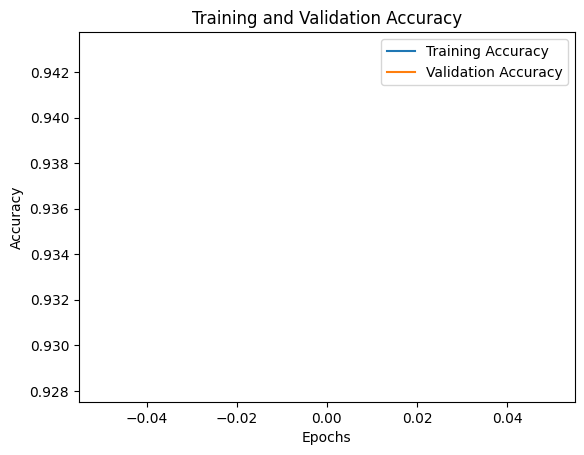

Female Suicides: 58183, Female Non-Suicides: 57839
Male Suicides: 57854, Male Non-Suicides: 58198
Enter a text to analyze: I am hungry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
Predicted class: Female


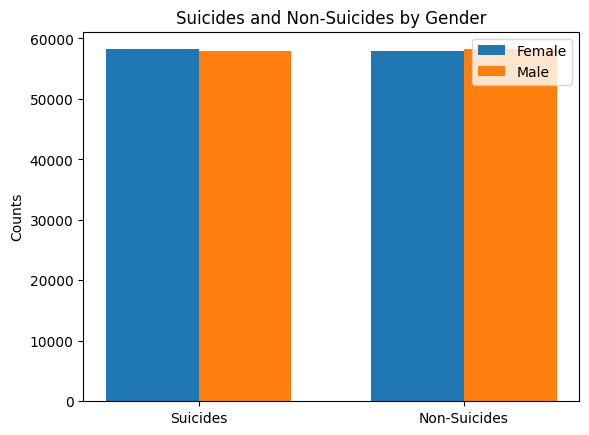

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Suicide_Detection.csv')

# Drop unnecessary columns
data = data.drop(columns='Unnamed: 0', errors='ignore')

# Add a 'gender' column with random assignment
np.random.seed(42)
data['gender'] = np.random.choice(['Female', 'Male'], size=len(data))

# Encode the labels
label_encoder = LabelEncoder()
data['class_encoded'] = label_encoder.fit_transform(data['class'])  # suicide: 1, non-suicide: 0
data['gender_encoded'] = label_encoder.fit_transform(data['gender'])  # Female: 0, Male: 1

# Tokenize and pad the text
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# Split the dataset
X = padded_sequences
y = data[['class_encoded', 'gender_encoded']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the CNN-BiLSTM model
input_layer = Input(shape=(100,))
embedding_layer = Embedding(input_dim=10000, output_dim=128, input_length=100)(input_layer)
conv_layer = Conv1D(64, kernel_size=3, activation='relu')(embedding_layer)
pooling_layer = MaxPooling1D(pool_size=2)(conv_layer)
bilstm_layer = Bidirectional(LSTM(64, return_sequences=False))(pooling_layer)
dropout_layer = Dropout(0.5)(bilstm_layer)
output_layer = Dense(2, activation='softmax')(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# Define the save paths
model_save_path = 'C:/Users/Manaswi/PycharmProjects/Suicidal_Identification/suicide_detection_model.h5'
tokenizer_save_path = 'C:/Users/Manaswi/PycharmProjects/Suicidal_Identification/tokenizer.pkl'

# Train the model
history = model.fit(X_train, y_train[:, 0], epochs=5, batch_size=64, validation_split=0.2)

# Save the trained model
#model.save('suicide_detection_model.h5')
model.save('C:/Users/Manaswi/PycharmProjects/Suicidal_Identification/suicide_detection_model.h5', save_format='h5')  # Save it again as .h5


# Save the tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

print("Model and tokenizer saved successfully.")

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test[:, 0])
print(f"Test Accuracy: {accuracy:.2f}")

# Plot the training and validation accuracy
if history.history:  # Ensure history is not empty
    print("Available keys in history:", history.history.keys())
    plt.plot(history.history.get('sparse_categorical_accuracy', []), label='Training Accuracy')
    plt.plot(history.history.get('val_sparse_categorical_accuracy', []), label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
else:
    print("No metrics logged in training history.")

# Analyze the number of suicides and non-suicides for females and males
female_data = data[data['gender'] == 'Female']
male_data = data[data['gender'] == 'Male']

female_suicides = female_data[female_data['class'] == 'suicide'].shape[0]
female_non_suicides = female_data[female_data['class'] == 'non-suicide'].shape[0]

male_suicides = male_data[male_data['class'] == 'suicide'].shape[0]
male_non_suicides = male_data[male_data['class'] == 'non-suicide'].shape[0]

print(f"Female Suicides: {female_suicides}, Female Non-Suicides: {female_non_suicides}")
print(f"Male Suicides: {male_suicides}, Male Non-Suicides: {male_non_suicides}")

# Plot bar chart for suicides and non-suicides by gender
gender_suicide_counts = {
    'Female': [female_suicides, female_non_suicides],
    'Male': [male_suicides, male_non_suicides]
}

labels = ['Suicides', 'Non-Suicides']
female_counts = gender_suicide_counts['Female']
male_counts = gender_suicide_counts['Male']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, female_counts, width, label='Female')
rects2 = ax.bar(x + width/2, male_counts, width, label='Male')

# Function to preprocess the user input
def preprocess_input(user_text, tokenizer, max_len=100):
    sequences = tokenizer.texts_to_sequences([user_text])
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return padded

# Take user input
user_text = input("Enter a text to analyze: ")

# Preprocess the input
preprocessed_input = preprocess_input(user_text, tokenizer)

# Predict using the model
prediction = model.predict(preprocessed_input)

# Decode the prediction
class_labels = label_encoder.classes_  # ['non-suicide', 'suicide']
predicted_class = class_labels[np.argmax(prediction)]

print(f"Predicted class: {predicted_class}")

ax.set_ylabel('Counts')
ax.set_title('Suicides and Non-Suicides by Gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout
import matplotlib.pyplot as plt
import pickle

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Suicide_Detection.csv')

# Drop unnecessary columns
data = data.drop(columns='Unnamed: 0', errors='ignore')

# Add a 'gender' column with random assignment
# np.random.seed(42)
# data['gender'] = np.random.choice(['Female', 'Male'], size=len(data))

# Separate encoders for class and gender
class_encoder = LabelEncoder()
data['class_encoded'] = class_encoder.fit_transform(data['class'])  # suicide: 1, non-suicide: 0

# gender_encoder = LabelEncoder()
# data['gender_encoded'] = gender_encoder.fit_transform(data['gender'])  # Female: 0, Male: 1

# Tokenize and pad the text
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# Split the dataset
X = padded_sequences
y = data[['class_encoded', 'gender_encoded']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the CNN-BiLSTM model
input_layer = Input(shape=(100,))
embedding_layer = Embedding(input_dim=10000, output_dim=128, input_length=100)(input_layer)
conv_layer = Conv1D(64, kernel_size=3, activation='relu')(embedding_layer)
pooling_layer = MaxPooling1D(pool_size=2)(conv_layer)
bilstm_layer = Bidirectional(LSTM(64, return_sequences=False))(pooling_layer)
dropout_layer = Dropout(0.5)(bilstm_layer)
output_layer = Dense(2, activation='softmax')(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

# Train the model
history = model.fit(X_train, y_train[:, 0], epochs=5, batch_size=64, validation_split=0.2)

# Save the trained model
model.save('C:/Users/Manaswi/Desktop/suicide_detection_model.h5')

# Save the tokenizer
with open('C:/Users/Manaswi/Desktop/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

print("Model and tokenizer saved successfully.")

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test[:, 0])
print(f"Test Accuracy: {accuracy:.2f}")

# Plot the training and validation accuracy
# plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()
# plt.show()

# Function to preprocess the user input
# def preprocess_input(user_text, tokenizer, max_len=100):
#     sequences = tokenizer.texts_to_sequences([user_text])
#     padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
#     return padded

# # Take user input
# user_text = input("Enter a text to analyze: ")

# # Preprocess the input
# preprocessed_input = preprocess_input(user_text, tokenizer)

# # Predict using the model
# prediction = model.predict(preprocessed_input)

# # Decode the prediction
# class_labels = class_encoder.classes_  # ['non-suicide', 'suicide']
# predicted_class = class_labels[np.argmax(prediction)]

# print(f"Predicted class: {predicted_class}")


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Define class labels based on the unique classes in the data
class_labels = data['class'].unique()  # ['non-suicide', 'suicide']

# Predict on the test set
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)  # Get the predicted class labels

# Calculate accuracy, precision, recall, and F1 score
print("\nClassification Report:")
print(classification_report(y_test[:, 0], y_test_pred_classes, target_names=class_labels))

# Calculate and print the accuracy
accuracy = accuracy_score(y_test[:, 0], y_test_pred_classes)
print(f"Test Accuracy: {accuracy:.2f}")




1451/1451 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step

Classification Report:
              precision    recall  f1-score   support

     suicide       0.92      0.95      0.94     23287
 non-suicide       0.95      0.92      0.93     23128

    accuracy                           0.94     46415
   macro avg       0.94      0.94      0.94     46415
weighted avg       0.94      0.94      0.94     46415

Test Accuracy: 0.94


In [ ]:
model.save('suicide_detection_model.h5')

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [ ]:
from google.colab import files
files.download('suicide_detection_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('tokenizer.pkl')

NameError: name 'files' is not defined

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.17.1


In [ ]:
def preprocess_input(user_text, tokenizer, max_len=100):
    sequences = tokenizer.texts_to_sequences([user_text])
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return padded

# Take user input
user_text = input("Enter a text to analyze: ")

# Preprocess the input
preprocessed_input = preprocess_input(user_text, tokenizer)

# Predict using the model
prediction = model.predict(preprocessed_input)

# Decode the prediction
class_labels = class_encoder.classes_  # ['non-suicide', 'suicide']
predicted_class = class_labels[np.argmax(prediction)]

print(f"Predicted class: {predicted_class}")


Enter a text to analyze: Happy life
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted class: suicide


In [ ]:
import pickle

# Save the tokenizer as a .pkl file
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

# Trigger the download in Colab
from google.colab import files
files.download('tokenizer.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('suicide_detection_model.h5')
model.save('suicide_detection_model_compatible.h5')


In [ ]:
model.save('C:/Users/Manaswi/PycharmProjects/Suicidal_Identification/suicide_detection_model.h5', save_format='h5')

In [ ]:
from google.colab import files
files.download('/content/suicide_detection_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>